In [105]:
import numpy as np
import pygad
import pygad.torchga as torchga
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchinfo import summary

In [106]:
# Load the iris dataset.
iris = load_iris()
X: np.ndarray = iris.data
y: np.ndarray = iris.target

In [107]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [108]:
# Scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [110]:
# Define the parameters.
sol_per_pop = 10
num_generations = 50

In [111]:
# Create the model.
model = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.Softmax(dim=1)
)

In [112]:
# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(
    model=model,
    num_solutions=sol_per_pop,
)

In [113]:
# batch_size = 16
summary(model, input_size=(1, 4))

C:\Users\diogo\miniconda3\envs\torch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\diogo\miniconda3\envs\torch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3]                    --
├─Linear: 1-1                            [1, 10]                   50
├─ReLU: 1-2                              [1, 10]                   --
├─Linear: 1-3                            [1, 3]                    33
├─Softmax: 1-4                           [1, 3]                    --
Total params: 83
Trainable params: 83
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [114]:
# Some parameters are initialized within the constructor.
initial_population = torch_ga.population_weights

In [115]:
# Define the loss function.
loss_fn = nn.CrossEntropyLoss()

In [116]:
# Define the fitness function for classification.
def fitness_func(_ga: pygad.GA, sol: np.ndarray, _sol_idx: int) -> float:
    preds = torchga.predict(model=model.cpu(),
                            solution=sol,
                            data=X_train)
    fitness = 1.0 / (loss_fn(preds, y_train).detach().numpy() + 1e-8)
    return fitness

In [117]:
# Define the callback function.
# noinspection PyShadowingNames
def on_generation(ga: pygad.GA) -> None:
    print(f'Generation: {ga.generations_completed}')
    print(f'Fitness: {ga.best_solution()[1]}')

In [118]:
# Create an instance of the GA class inside the ga module.
ga = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=sol_per_pop // 2,
    initial_population=initial_population,
    fitness_func=fitness_func,
    on_generation=on_generation,
)

In [119]:
# Run the genetic algorithm.
ga.run()

Generation: 1
Fitness: 1.1943092610866668
Generation: 2
Fitness: 1.1943092610866668
Generation: 3
Fitness: 1.1943092610866668
Generation: 4
Fitness: 1.210569738793921
Generation: 5
Fitness: 1.2559331383311585
Generation: 6
Fitness: 1.2559331383311585
Generation: 7
Fitness: 1.2878498820926414
Generation: 8
Fitness: 1.314872926725201
Generation: 9
Fitness: 1.314872926725201
Generation: 10
Fitness: 1.3157298296636963
Generation: 11
Fitness: 1.3422351391640255
Generation: 12
Fitness: 1.3691346465685466
Generation: 13
Fitness: 1.387121897342027
Generation: 14
Fitness: 1.387121897342027
Generation: 15
Fitness: 1.4298874735648246
Generation: 16
Fitness: 1.4298874735648246
Generation: 17
Fitness: 1.4298874735648246
Generation: 18
Fitness: 1.4368728115362817
Generation: 19
Fitness: 1.4368728115362817
Generation: 20
Fitness: 1.4546745770812497
Generation: 21
Fitness: 1.4546745770812497
Generation: 22
Fitness: 1.4546745770812497
Generation: 23
Fitness: 1.4546745770812497
Generation: 24
Fitness: 1

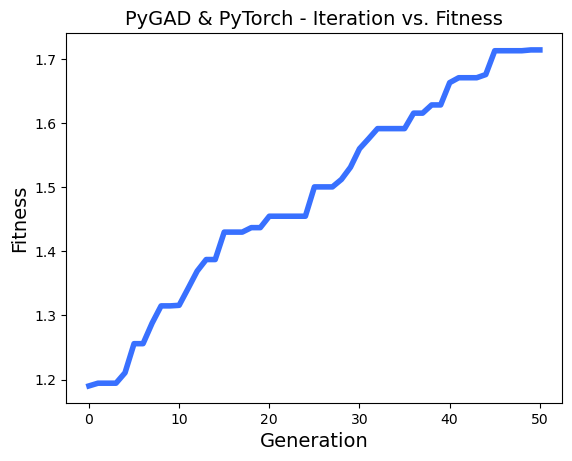

In [120]:
# After the generations complete, some plots are shown that summarize
# how the outputs/fitness values evolve over generations.
_ = ga.plot_fitness(
    title="PyGAD & PyTorch - Iteration vs. Fitness",
    linewidth=4
)

In [121]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga.best_solution()
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

Fitness value of the best solution = 1.7139750574673012
Index of the best solution : 0


In [123]:
# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(
    model=model,
    weights_vector=solution
)
model.load_state_dict(best_solution_weights)

<All keys matched successfully>

In [140]:
# Calculate the predictions of the best solution.
def calculate_metrics(x: torch.Tensor, yt: torch.Tensor) -> None:
    preds = model(x)
    # Calculate the crossentropy loss of the trained model.
    loss = loss_fn(preds, yt).detach().numpy()
    print(f"Crossentropy : {loss}")
    # Calculate the classification accuracy for the trained model.
    preds = preds.detach().numpy()
    yt = yt.detach().numpy()
    acc = np.sum(np.argmax(preds, axis=1) == yt) / len(yt)
    print(f"Accuracy : {acc}")

In [145]:
print("On the training set:")
calculate_metrics(X_train, y_train)

On the training set:
Crossentropy : 0.58343905210495
Accuracy : 0.9703703703703703


In [146]:
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the testing set:
Crossentropy : 0.5824460983276367
Accuracy : 1.0
